## 핸즈온 머신러닝 14장 RNN 해보기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
#28x28 픽셀인 MNIST 이미지 학습시켜 보기
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outpus = 10

learning_rate = 0.001
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) #states 텐서는 마지막 28번째 출력만 담고 있음
logits = tf.layers.dense(states, n_outpus)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, n_steps * n_inputs) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, n_steps * n_inputs) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
X_test = X_test.reshape((-1, n_steps, n_inputs))
X_valid = X_valid.reshape((-1, n_steps, n_inputs))

In [7]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [8]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict = {X: X_batch, y:y_batch})
        acc_batch = accuracy.eval(feed_dict = {X: X_batch, y:y_batch})
        acc_valid = accuracy.eval(feed_dict = {X: X_valid, y:y_valid})
        if epoch % 5 == 0 || epoch == 99: #5번째마다 or 마지막 결과 출력
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

0 배치 데이터 정확도: 0.96666664 검증 세트 정확도: 0.9368
1 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.95
2 배치 데이터 정확도: 0.9533333 검증 세트 정확도: 0.9576
3 배치 데이터 정확도: 0.9533333 검증 세트 정확도: 0.967
4 배치 데이터 정확도: 0.9866667 검증 세트 정확도: 0.9696
5 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.972
6 배치 데이터 정확도: 0.99333334 검증 세트 정확도: 0.9726
7 배치 데이터 정확도: 0.99333334 검증 세트 정확도: 0.9738
8 배치 데이터 정확도: 0.99333334 검증 세트 정확도: 0.9798
9 배치 데이터 정확도: 0.97333336 검증 세트 정확도: 0.972
10 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.978
11 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9796
12 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9706
13 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9814
14 배치 데이터 정확도: 0.9866667 검증 세트 정확도: 0.982
15 배치 데이터 정확도: 0.97333336 검증 세트 정확도: 0.9778
16 배치 데이터 정확도: 0.99333334 검증 세트 정확도: 0.9714
17 배치 데이터 정확도: 0.96666664 검증 세트 정확도: 0.9722
18 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.979
19 배치 데이터 정확도: 0.9866667 검증 세트 정확도: 0.9734
20 배치 데이터 정확도: 0.99333334 검증 세트 정확도: 0.9798
21 배치 데이터 정확도: 0.99333334 검증 세트 정확도: 0.9788
22 배치 데이터 정확도: 0.9866667 검증 세트 정확도: 0.9804
23 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9788
24 배치 데이터 정확도: 0.

## 시계열 데이터 예측
홈페이지에 있는 코드

In [6]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t * 5)

def next_batch(batch_size, n_steps): #randn: batch_size * 1 크기의 0~1 난수 배열 생성
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Text(0.5, 0, '시간')

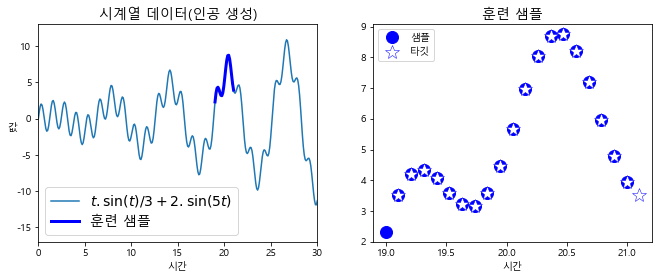

In [52]:
# np.linspace(0, 100, 5) -> 0~100 구간을 5개로 나눔
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
init_num = np.random.randint(20)
t_instance = np.linspace(init_num, init_num + resolution * (n_steps + 1), n_steps + 1)

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'malgun gothic')

#첫번째 plot
plt.figure(figsize = (11,4))
plt.subplot(121) #1행 2열의 첫번째 subplot
plt.title("시계열 데이터(인공 생성)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t.\sin(t)/3 + 2.\sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="훈련 샘플")
plt.legend(loc = "lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("시간")
plt.ylabel("값", rotation=0)

#두번째 plot
plt.subplot(122)
plt.title("훈련 샘플", fontsize=14)
#샘플은 마지막꺼 제외한 것
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
#타깃은 첫번째꺼 제외한 것
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5,
         markeredgecolor="b", markersize=14, label="타깃")
plt.legend(loc = "upper left")
plt.xlabel("시간")

In [50]:
print(np.random.randint(30)) #0부터 30까지 랜덤한 정수 1개
print(np.random.randint(25, 30)) #25부터 30까지 랜덤한 정수 1개
print(np.random.randint(0, 30, 10)) #0부터 30까지 랜덤한 정수 10개
print(np.random.rand(6)) # 0 ~ 1의 균일분포 난수 6개
print(np.random.rand(3,2)) # 0 ~ 1의 균일분포 난수 3 * 2개
print(np.random.randn(6)) # 평균 0, 표준편차 1인 표준정규분포 난수 6개
print(np.random.randn(3,2)) # 평균 0, 표준편차 1인 표준정규분포 난수 3*2개

21
28
[11  8  0  5 14 15 19  0 14  0]
[0.1230884  0.30870474 0.95400239 0.74446489 0.50396561 0.48467929]
[[0.09376476 0.41582723]
 [0.0549341  0.98102361]
 [0.26251497 0.33111017]]
[-0.25212748  0.31427372  0.85742012 -1.15054084 -0.46529831 -0.18028542]
[[ 0.50638442 -0.57218649]
 [-0.2405407  -0.31379618]
 [ 0.69410081 -0.15980078]]


## 시계열 예측을 위해 훈련하기
책에 있는 코드

In [2]:
#100개의 순환 뉴런, 각 훈련 샘플은 20개, 각 입력은 하나의 특성만 가짐(해당 시간에서의 값)
n_steps = 20
n_inputs = 1
n_neurons = 100 # 각 step에서 크기 100의 출력 벡터를 가짐
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) #[None,20,1]
y = tf.placeholder(tf.float32, [None, n_outputs]) #[None,1]
#cell = tf.keras.layers.SimpleRNNCell(units=n_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(
tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
#outputs는 각 cell에서 출력값, states는 마지막 출력값?

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [3]:
#cost function 정의. regression이므로 MSE 계산하기
learning_rate = 0.01

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [4]:
saver = tf.train.Saver()

In [53]:
n_iterations = 1500
batch_size = 50

t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t * 5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (30 - n_steps * resolution)
    #print(t0.shape) #50,1
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    #print(Ts.shape) #50,21
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, -1].reshape(-1, 1)

X_imsi, y_imsi = next_batch(batch_size, n_steps)
print(X_imsi.shape) #(50,20,1)이 되어야 함
print(y_imsi.shape) #(50,1)이 되어야 함

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict = {X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict = {X: X_batch, y:y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")

(50, 20, 1)
(50, 1)


InvalidArgumentError: Incompatible shapes: [50,20,1] vs. [50,1]
	 [[node gradients/sub_grad/BroadcastGradientArgs (defined at <ipython-input-3-328a646b55bb>:6)  = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](gradients/sub_grad/Shape, gradients/sub_grad/Shape_1)]]

Caused by op 'gradients/sub_grad/BroadcastGradientArgs', defined at:
  File "C:\Users\ejesu\.conda\envs\test\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ejesu\.conda\envs\test\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\ejesu\.conda\envs\test\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\ejesu\.conda\envs\test\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\ejesu\.conda\envs\test\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-328a646b55bb>", line 6, in <module>
    training_op = optimizer.minimize(loss)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\training\optimizer.py", line 400, in minimize
    grad_loss=grad_loss)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\training\optimizer.py", line 519, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 630, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 408, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\math_grad.py", line 923, in _SubGrad
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 814, in broadcast_gradient_args
    "BroadcastGradientArgs", s0=s0, s1=s1, name=name)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'sub', defined at:
  File "C:\Users\ejesu\.conda\envs\test\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 25 identical lines from previous traceback]
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-328a646b55bb>", line 4, in <module>
    loss = tf.reduce_mean(tf.square(outputs - y))
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\math_ops.py", line 866, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 8912, in sub
    "Sub", x=x, y=y, name=name)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\ejesu\.conda\envs\test\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [50,20,1] vs. [50,1]
	 [[node gradients/sub_grad/BroadcastGradientArgs (defined at <ipython-input-3-328a646b55bb>:6)  = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](gradients/sub_grad/Shape, gradients/sub_grad/Shape_1)]]


In [47]:
np.arange(0., 21)

21